In [1]:
import cv2
import numpy as np
from glob import glob
import json
from tqdm import tqdm
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
start_time = '20210804_200121'

metadata_list = glob(f'dataset/{start_time}/metadata*.json')

len(metadata_list)

1363

In [3]:
img_size = 299

x_data = np.zeros((len(metadata_list) * 5, img_size, img_size, 3), dtype=np.float32)
y_data = np.zeros((len(metadata_list) * 5, 2), dtype=np.float32)

i = 0

for metadata_path in tqdm(metadata_list):
    with open(metadata_path, 'r') as f:
        metadata_5 = json.load(f)

        for metadata in metadata_5:
            img = cv2.imread(f'dataset/{start_time}/{metadata["img_path"]}')
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype(np.float32)
            img = img / 127.5 - 1.
            
            x_data[i] = img
            y_data[i] = [metadata['lat'], metadata['lng']]

            i += 1

print(x_data.shape, y_data.shape)

100%|██████████| 1363/1363 [01:39<00:00, 13.68it/s]

(6815, 299, 299, 3) (6815, 2)


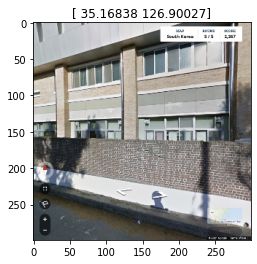

In [4]:
import matplotlib.pyplot as plt

plt.title(str(y_data[-1]))
plt.imshow((x_data[-1, :, :, ::-1] + 1.) / 2.)

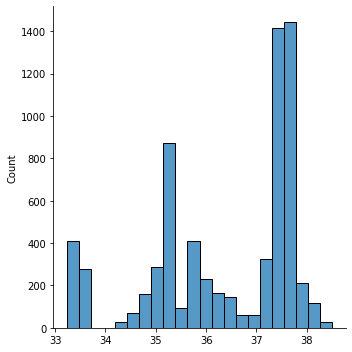

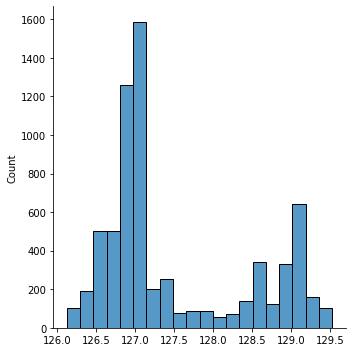

In [5]:
import seaborn as sns

sns.displot(y_data[:, 0])
sns.displot(y_data[:, 1])

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

y_data_scaled = scaler.fit_transform(y_data)

print(y_data_scaled[0])
print(scaler.data_min_, scaler.data_max_)

[0.8731117  0.28050613]
[ 33.231125 126.1239  ] [ 38.50748 129.52641]


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data_scaled, test_size=0.2, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5452, 299, 299, 3) (5452, 2)
(1363, 299, 299, 3) (1363, 2)


In [8]:
from tensorflow.keras.applications import Xception, EfficientNetB3, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [9]:
model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=8,
    epochs=100
)

Epoch 1/100
682/682 [==============================] - 109s 160ms/step - loss: 0.0863 - mae: 0.2430 - val_loss: 0.0668 - val_mae: 0.2258
Epoch 2/100
682/682 [==============================] - 109s 160ms/step - loss: 0.0629 - mae: 0.2121 - val_loss: 0.0765 - val_mae: 0.2059
Epoch 3/100
682/682 [==============================] - 110s 161ms/step - loss: 0.0561 - mae: 0.1948 - val_loss: 0.0727 - val_mae: 0.2132
Epoch 4/100
682/682 [==============================] - 109s 161ms/step - loss: 0.0494 - mae: 0.1784 - val_loss: 0.0628 - val_mae: 0.1953
Epoch 5/100
682/682 [==============================] - 110s 161ms/step - loss: 0.0439 - mae: 0.1632 - val_loss: 0.0776 - val_mae: 0.2009
Epoch 6/100
682/682 [==============================] - 109s 159ms/step - loss: 0.0378 - mae: 0.1466 - val_loss: 0.0634 - val_mae: 0.1933
Epoch 7/100
682/682 [==============================] - 108s 159ms/step - loss: 0.0317 - mae: 0.1299 - val_loss: 0.0620 - val_mae: 0.1916
Epoch 8/100
682/682 [====================

KeyboardInterrupt: 

In [10]:
y_pred = model.predict(x_val[:64])

y_pred_iscaled = scaler.inverse_transform(y_pred)

y_pred_iscaled[:5]

array([[ 35.503773, 128.88153 ],
       [ 36.387547, 128.78485 ],
       [ 37.507736, 127.00185 ],
       [ 37.61241 , 126.97166 ],
       [ 37.697346, 126.93138 ]], dtype=float32)

In [11]:
import folium

m = folium.Map(location=[36.91115, 127.153305])

for coords in y_pred_iscaled:
    folium.Marker([coords[0], coords[1]], popup=f"{str(coords)}").add_to(m)
m

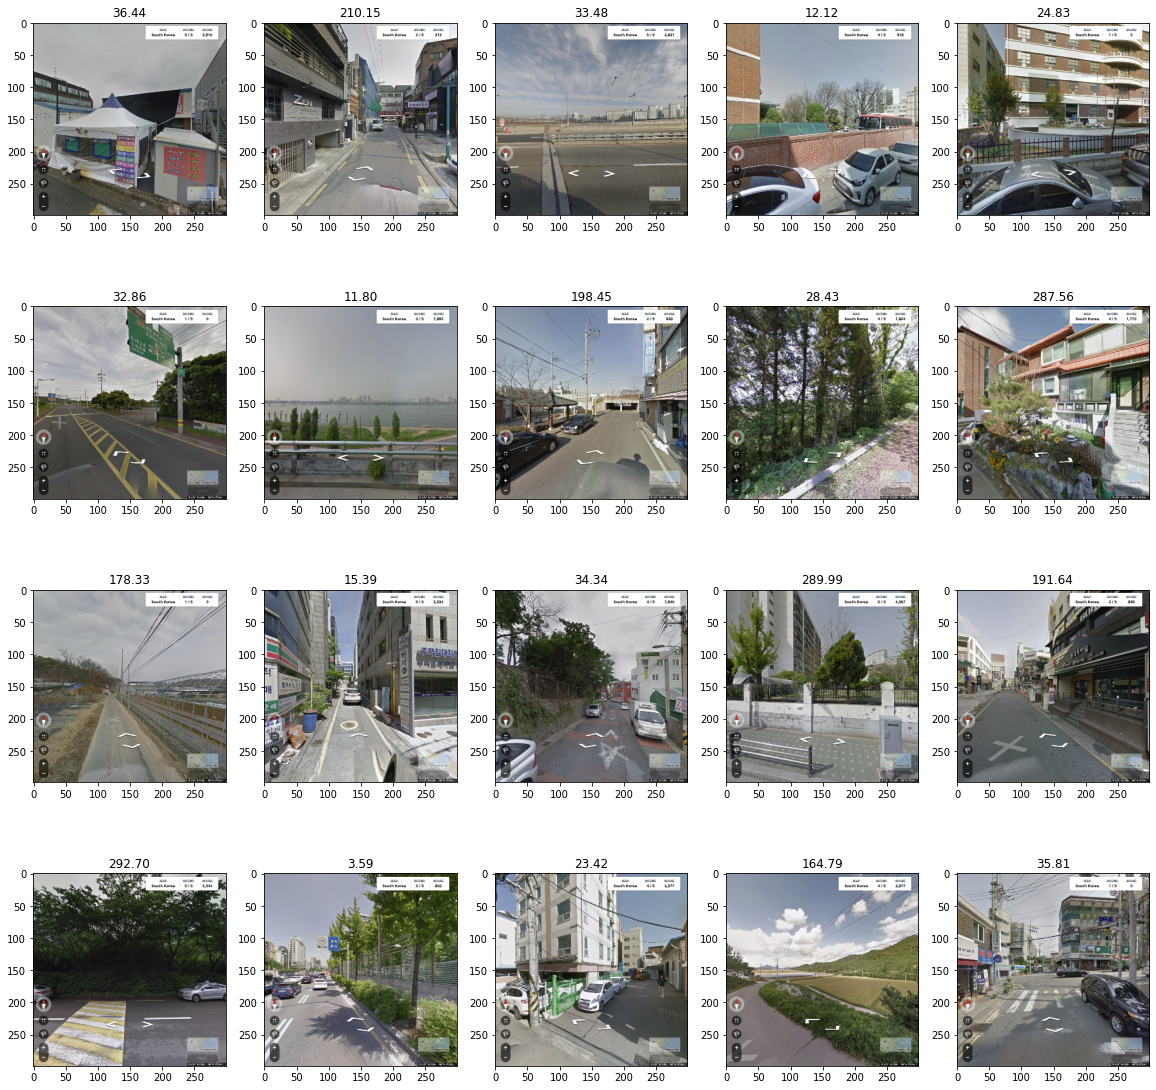

In [14]:
from geopy.distance import geodesic

y_true = scaler.inverse_transform(y_val)

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for x, y, y_hat, ax in zip(x_val, y_true, y_pred_iscaled, axes.flatten()):
    ax.imshow((x[:, :, ::-1] + 1) / 2)
    ax.set_title('%.2f' % geodesic(y, y_hat).kilometers)